# PZ model simulation

In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

**Xây dựng mô hình**

In [3]:
##1 Model
def pz_model(t, y, p):
    P, Z = y

    # Unpack parameters from dictionary
    N = p['N']
    mu = p['mu']
    alpha1 = p['alpha1']
    beta1 = p['beta1']
    v = p['v']
    a = p['a']
    u = p['u']
    alpha2 = p['alpha2']
    h = p['h']
    beta2 = p['beta2']
    rho = p['rho']
    delta1 = p['delta1']
    delta2 = p['delta2']
    nu1 = p['nu1']
    nu2 = p['nu2']

    # Common term for hunting efficiency
    term = 1.0 + (a * v) / (a**2 + v**2)
    functional_response = (alpha2 + h * (1 - u) * P)

    # Calculate dP/dt
    dPdt = (mu * N * P / (alpha1 + N)) - \
           (beta1 * term * (1 - u) * P * Z / functional_response) - \
           (delta1 * P**2) - (nu1 * P**3)

    # Calculate dZ/dt
    dZdt = (beta2 * term * (1 - u) * P * Z / functional_response) - \
           (beta2 * rho * P**(2/3) * Z) - \
           (delta2 * Z) - (nu2 * Z**2)

    return [dPdt, dZdt]

##2 Giai PTVP
def differential_equation(p, P0=2.0, Z0=1.0, T=300.0, dt=0.1):
    t_eval = np.arange(0, T + dt, dt)
    sol = solve_ivp(
        fun=lambda t, y: pz_model(t, y, p),
        t_span=(0, T),
        y0=[P0, Z0],
        t_eval=t_eval,
        method="RK45",
        rtol=1e-6,
        atol=1e-9
    )
    P = np.maximum(sol.y[0], 0.0)
    Z = np.maximum(sol.y[1], 0.0)
    return sol.t, P, Z

##2 Kiểm tra tính ổn định địa phương
def check_local_stability(p, P_star, Z_star):
    # Unpack parameters from dictionary
    N = p['N']
    mu = p['mu']
    alpha1 = p['alpha1']
    beta1 = p['beta1']
    v = p['v']
    a = p['a']
    u = p['u']
    alpha2 = p['alpha2']
    h = p['h']
    beta2 = p['beta2']
    rho = p['rho']
    delta1 = p['delta1']
    delta2 = p['delta2']
    nu1 = p['nu1']
    nu2 = p['nu2']

    # Common term for hunting efficiency
    term = 1.0 + (a * v) / (a**2 + v**2)
    functional_response = (alpha2 + h * (1 - u) * P_star)

    is_stable = True
    if (Z_star == 0):
      if (beta2 * term * (1 - u) * P_star * Z_star / functional_response - beta2 * rho * P_star**(2/3) - delta2) > 0:
          is_stable = False
          print(f"Điểm cân bằng E=({P_star}, {Z_star}) không ổn định địa phương")
      else:
          print(f"Điểm cân bằng E=({P_star}, {Z_star}) ổn định địa phương" )
    else:
      j_11 = -(delta1 * P_star + 2 * nu1 * P_star**2) + (beta1 * term * (1 - u)**2 * h * P_star * Z_star / functional_response**2)
      j_12 = -beta1 * term * (1 - u) * P_star / functional_response
      j_21 = beta2 * term * (1 - u) * alpha2 * Z_star / functional_response**2 - 2/3 * beta2 * rho * P_star**(-1/3) * Z_star
      j_22 = - nu2 * Z_star
      if (j_11 + j_22 < 0 and j_11 * j_12 + j_12 * j_21 > 0):
          is_stable = False
          print(f"Điểm cân bằng E=({P_star:.4f}, {Z_star:.4f}) ổn định địa phương" )
      else:
        print(f"Điểm cân bằng E=({P_star:.4f}, {Z_star:.4f}) không ổn định địa phương")


In [9]:
##1 Vẽ đồ thị biểu diễn theo thời gian T
def plot_time_series(p, P0=2.0, Z0=1.0, T=300.0):
    t, P, Z = differential_equation(p, P0, Z0, T, dt=0.1)
    plt.figure(figsize=(5, 4))
    plt.plot(t, P, label="P(t)", linewidth=1)
    plt.plot(t, Z, label="Z(t)", linewidth=1)
    plt.xlabel("T")
    plt.ylabel("P & Z")
    # plt.title(f"Đồ thị biểu diễn mật độ động vật phù du và thực vật phù du theo thời gian với P0 = {P0}, Z0 = {Z0}")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

##2 Vẽ surface 3D
def surface_plot(ax, grid_x, grid_y, surface_values, xlabel, ylabel, zlabel, title, cmap):
    ax.plot_surface(grid_x, grid_y, surface_values, linewidth=0.2, antialiased=True, cmap=cmap)
    ax.grid(True)
    ax.xaxis._axinfo["grid"]['linestyle'] = '--'
    ax.yaxis._axinfo["grid"]['linestyle'] = '--'
    ax.zaxis._axinfo["grid"]['linestyle'] = '--'

    ax.xaxis._axinfo["grid"]['alpha'] = 0.4
    ax.yaxis._axinfo["grid"]['alpha'] = 0.4
    ax.zaxis._axinfo["grid"]['alpha'] = 0.4
    ax.xaxis._axinfo["grid"]['linewidth'] = 0.6
    ax.yaxis._axinfo["grid"]['linewidth'] = 0.6
    ax.view_init(elev=25, azim=-60)
    ax.tick_params(labelsize=9)
    ax.set_xlabel(xlabel, labelpad=8)
    ax.set_ylabel(ylabel, labelpad=8)
    ax.set_zlabel(zlabel, labelpad=0.5)
    ax.zaxis.set_label_coords(1.08, 0.5)
    ax.zaxis.set_rotate_label(False)
    ax.set_title(title)

##3 Thống kê dài hạn: mean / min / max / amplitude
def long_run_metrics(p, P0=2.5, Z0=0.5, T=1000.0, dt=0.2, tail=200.0):
    t, P, Z = differential_equation(p, P0, Z0, T, dt)
    mask = t >= (T - tail)
    P_tail = P[mask]
    Z_tail = Z[mask]

    # mức trung bình dài hạn
    P_mean = float(np.mean(P_tail))
    Z_mean = float(np.mean(Z_tail))
    P_min = float(np.min(P_tail))
    Z_min = float(np.min(Z_tail))
    P_max = float(np.max(P_tail))
    Z_max = float(np.max(Z_tail))

    # biên độ dao động (để thấy switch on/off)
    P_amp = float(np.max(P_tail) - np.min(P_tail))
    Z_amp = float(np.max(Z_tail) - np.min(Z_tail))

    return P_mean, Z_mean, P_amp, Z_amp, P_min, Z_min, P_max, Z_max

##4 Vẽ đồ thị biểu diễn bề mặt quét 2 tham số mô hình
def sweep_and_plot_2params(
    base_params,
    param_x, x_vals,
    param_y, y_vals,
    metric="mean",
    fig_title_prefix=""
):
    """
    Quét 2 tham số (param_x, param_y) và vẽ surface cho P và Z.
    metric: "mean" hoặc "amp"
    """

    X, Y = np.meshgrid(x_vals, y_vals, indexing="xy")

    Psurf = np.zeros_like(X, dtype=float)
    Zsurf = np.zeros_like(X, dtype=float)

    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            p = dict(base_params)
            p[param_x] = float(X[i, j])
            p[param_y] = float(Y[i, j])

            P_mean, Z_mean, P_amp, Z_amp = long_run_metrics(p)
            if metric == "mean":
                Psurf[i, j] = P_mean
                Zsurf[i, j] = Z_mean
            elif metric == "amp":
                Psurf[i, j] = P_amp
                Zsurf[i, j] = Z_amp
            else:
                raise ValueError("metric must be 'mean' or 'amp'")

    # Vẽ 2 surface trong 1 figure
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")

    if metric == "mean":
        cmap = "viridis"
    elif metric == "amp":
        cmap = "plasma"
    surface_plot(
        ax1, X, Y, Psurf,
        xlabel=fr"${param_map[param_x]}$",
        ylabel=fr"${param_map[param_y]}$",
        zlabel=r"$P$",
        title=f"{fig_title_prefix}P over ({param_x}, {param_y}) - metric={metric}",
        cmap=cmap
    )

    surface_plot(
        ax2, X, Y, Zsurf,
        xlabel=fr"${param_map[param_x]}$",
        ylabel=fr"${param_map[param_y]}$",
        zlabel=r"$Z$",
        title=f"{fig_title_prefix}Z over ({param_x}, {param_y}) - metric={metric}",
        cmap=cmap
    )

    plt.subplots_adjust(
        left=0.05,
        right=0.87,
        bottom=0.08,
        top=0.92,
        wspace=0.08
    )
    plt.show()

    # return X, Y, Psurf, Zsurf

Tham số mô hình

In [ ]:
# Parameters
N = 5         # Mức dinh dưỡng trong hệ thống từ các nguồn khác nhau
mu = 0.4       # Tốc độ tăng trưởng của thực vật phù du do dinh dưỡng
alpha1 = 2.5   # Hằng số bán bão hòa của tăng trưởng thực vật phù du do dinh dưỡng
beta1 = 0.3    # Tốc độ tiêu thụ thực vật phù du của động vật phù du
v = 2.5        # Vận tốc dòng chảy 0.1, 1, 2.5
a = 1          # Tham số trong hàm hiệu suất săn mồi của động vật phù du phụ thuộc vào dòng chảy
u = 0.75       # Tỷ lệ thực vật phù du kết tụ thành các mảng
alpha2 = 0.1   # Hằng số bán bão hòa của thực vật phù du trong quá trình săn mồi
h = 0.4        # Tham số trong hàm phản ứng chức năng của quá trình săn mồi
beta2 = 0.09   # Tỷ lệ chuyển đổi sinh khối thực vật phù du thành sinh khối động vật phù du 0.09, 0.05
rho = 0.2823   # Tốc độ sản sinh độc tố
delta1 = 0.1   # Hệ số tử vong của thực vật phù du
delta2 = 0.1   # Hệ số tử vong tự nhiên của động vật phù du
nu1 = 0.02     # Hệ số tác động của độc tố lên thực vật phù du
nu2 = 0.01     # Hệ số tác động của độc tố lên động vật phù du
m = 5          # Số lượng các mảng (not used in the ODEs directly)

# Group parameters into a dictionary for easier access by name
params = {
    'N': N, 'mu': mu, 'alpha1': alpha1, 'beta1': beta1, 'v': v, 'a': a, 'u': u,
    'alpha2': alpha2, 'h': h, 'beta2': beta2, 'rho': rho, 'delta1': delta1,
    'delta2': delta2, 'nu1': nu1, 'nu2': nu2
}

# Map type latex
param_map = {
    "v": r"v",
    "mu": r"\mu",
    "alpha1": r"\alpha_1",
    "alpha2": r"\alpha_2",
    "beta1": r"\beta_1",
    "beta2": r"\beta_2",
    "delta1": r"\delta_1",
    "delta2": r"\delta_2",
    "rho": r"\rho",
    "nu1": r"\nu_1",
    "nu2": r"\nu_2",
    "N": r"N",
    "a": r"a",
    "h": r"h",
    "u": r"u"
}

**Tìm điểm cân bằng E và kiểm tra tính ổn định của E**

In [22]:
# Khởi tạo điều kiện ban đầu
initial_conditions = [
    (0.50, 0.3),
    (2.50, 0.50),
    (2.38, 0.45),
    (2.25, 0.4),
    (2.12, 0.35)
]
equilibria = []

# Tìm điểm cân bằng và kiểm tra tính ổn định địa phương
for y0 in initial_conditions:
    _, P, Z = differential_equation(params, y0[0], y0[1], T=300 )
    P_star = P[-1]
    Z_star = Z[-1]
    equilibria.append((P_star, Z_star))
    print(f"Khởi tạo (P_0, Z_0) {y0} → Điểm cân bằng ({P_star:.4f}, {Z_star:.4f})")
    check_local_stability(params, P_star, Z_star)

Khởi tạo (P_0, Z_0) (0.5, 0.3) → Điểm cân bằng (0.6500, 0.2637)
Điểm cân bằng E=(0.6500, 0.2637) không ổn định địa phương
Khởi tạo (P_0, Z_0) (2.5, 0.5) → Điểm cân bằng (0.8115, 0.3335)
Điểm cân bằng E=(0.8115, 0.3335) không ổn định địa phương
Khởi tạo (P_0, Z_0) (2.38, 0.45) → Điểm cân bằng (0.7172, 0.3555)
Điểm cân bằng E=(0.7172, 0.3555) không ổn định địa phương
Khởi tạo (P_0, Z_0) (2.25, 0.4) → Điểm cân bằng (0.6231, 0.3670)
Điểm cân bằng E=(0.6231, 0.3670) không ổn định địa phương
Khởi tạo (P_0, Z_0) (2.12, 0.35) → Điểm cân bằng (0.5493, 0.3691)
Điểm cân bằng E=(0.5493, 0.3691) không ổn định địa phương


**Vẽ đồ thị trực quan tính ổn định**

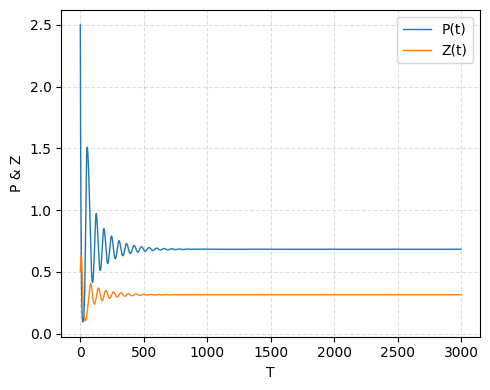

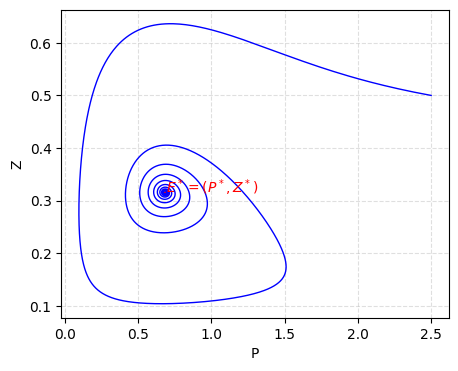

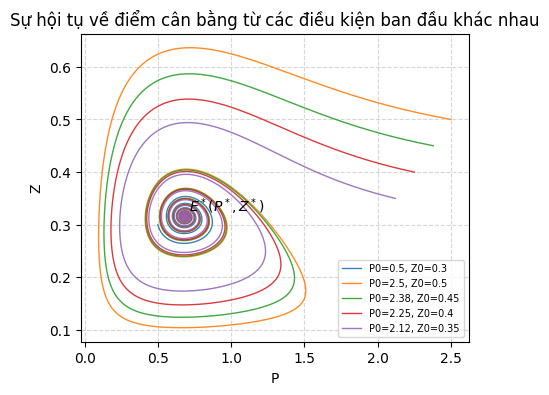

In [42]:
# Time series với tham số mặc định
P0 = initial_conditions[1][0]
Z0 = initial_conditions[1][1]
### 1 Đồ thị mật độ thực vật phù du và động vật phù du theo thời gian
plot_time_series(params, P0, Z0, T=3000)

### 2 Đồ thị quỹ đạo pha với (P0, Z0)
plt.figure(figsize=(5,4))

# Giai PTVP
T, P, Z = differential_equation(params, P0, Z0, T=600)
plt.plot(P, Z, linewidth=1, color="blue")

# Lấy tọa độ điểm cuối
P_end = P[-1]
Z_end = Z[-1]
# Vẽ điểm cuối

# Gắn nhãn tọa độ
plt.scatter(P_end, Z_end, s=10, color='red')
plt.annotate(
    # f"({P_end:.4f}, {Z_end:.4f})",
    fr"$E^*=(P^*, Z^*)$",
    xy=(P_end, Z_end + 0.1),
    xytext=(P_end, Z_end),
    # arrowprops=dict(arrowstyle="->", color="red"),
    fontsize=10,
    color="red"
)
plt.xlabel("P")
plt.ylabel("Z")
# plt.title(f"Sự hội tụ về điểm cân bằng từ các điều kiện P0 = {P0}, Z0 = {Z0}")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

### 3 Đồ thị quỹ đạo pha với các (P0, Z0) khác nhau
plt.figure(figsize=(5,4))

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
for (y0, c) in zip(initial_conditions, colors):
    # Giai PTVP
    _, P, Z = differential_equation(params, y0[0], y0[1], 3000)
    plt.plot(
        P, Z,
        color=c,
        linewidth=1,
        alpha=0.9,
        label=f"P0={y0[0]}, Z0={y0[1]}"
    )

plt.xlabel("P")
plt.ylabel("Z")
plt.text(P[-1] + 0.03, Z[-1] + 0.01, r"$E^*(P^*, Z^*)$")
plt.title("Sự hội tụ về điểm cân bằng từ các điều kiện ban đầu khác nhau")
plt.legend(fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



**Đồ thị bề mặt 3D**

/tmp/ipython-input-1567656643.py:33: RuntimeWarning: invalid value encountered in scalar power
  (beta2 * rho * P**(2/3) * Z) - \


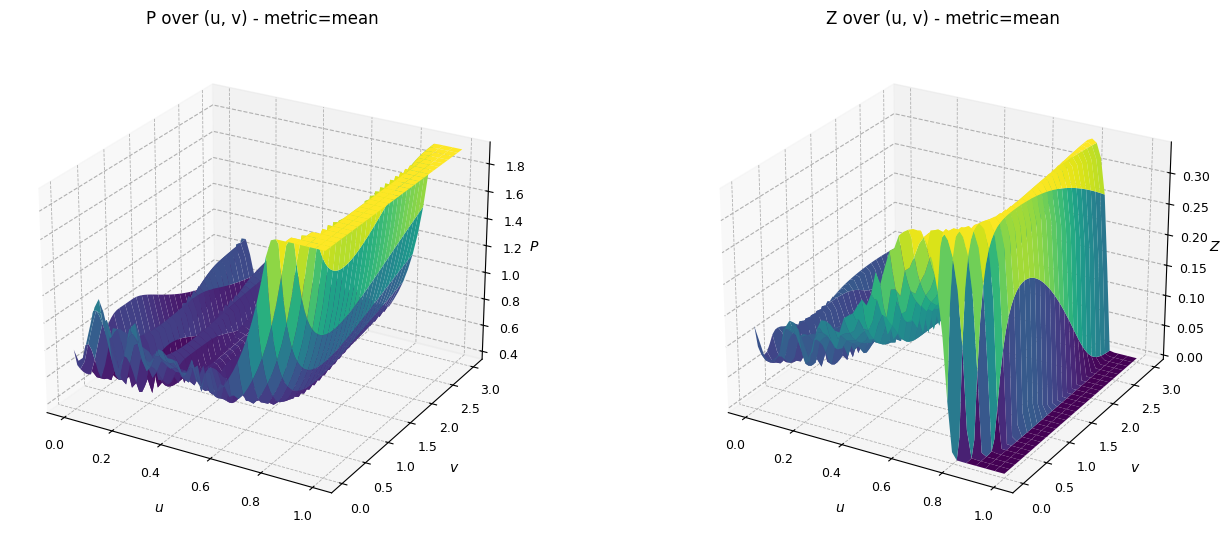

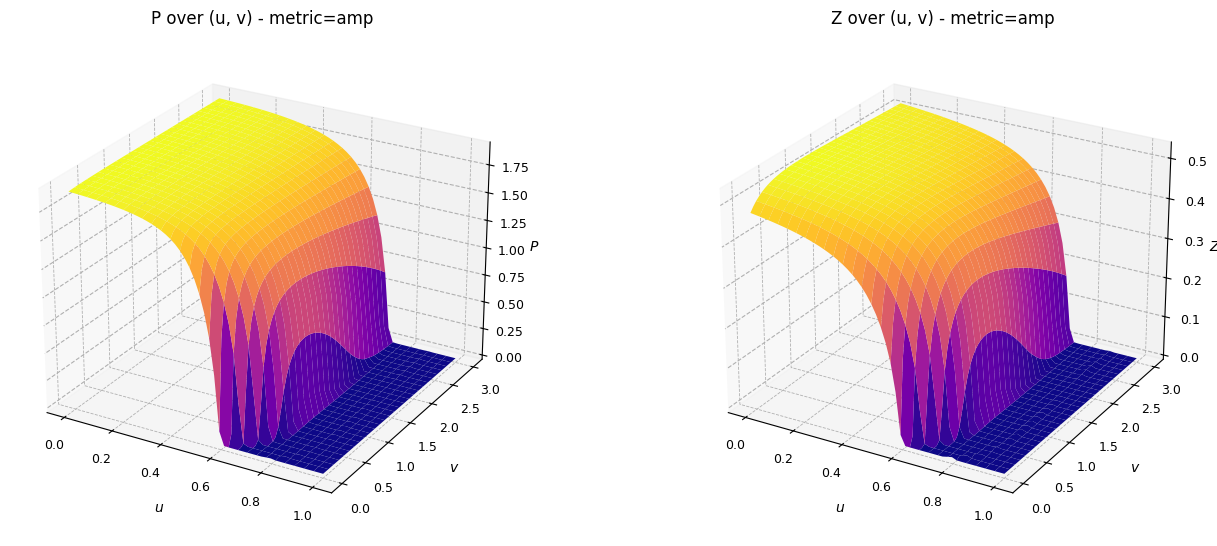

In [ ]:
# Surface quét (u, v)
u_vals = np.linspace(0, 1, 55) # giảm quét lưới tham số để chạy nhanh hơn 30, 40, 55
v_vals = np.linspace(0, 3, 55)

sweep_and_plot_2params(params, "u", u_vals, "v", v_vals, metric="mean")
sweep_and_plot_2params(params, "u", u_vals, "v", v_vals, metric="amp")

/tmp/ipython-input-1567656643.py:33: RuntimeWarning: invalid value encountered in scalar power
  (beta2 * rho * P**(2/3) * Z) - \


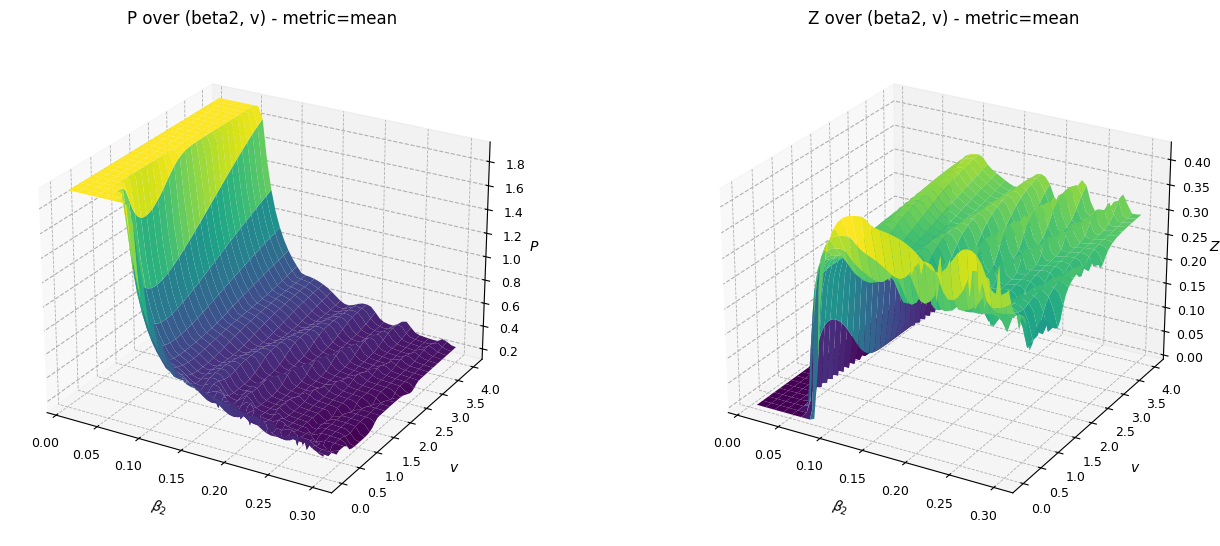

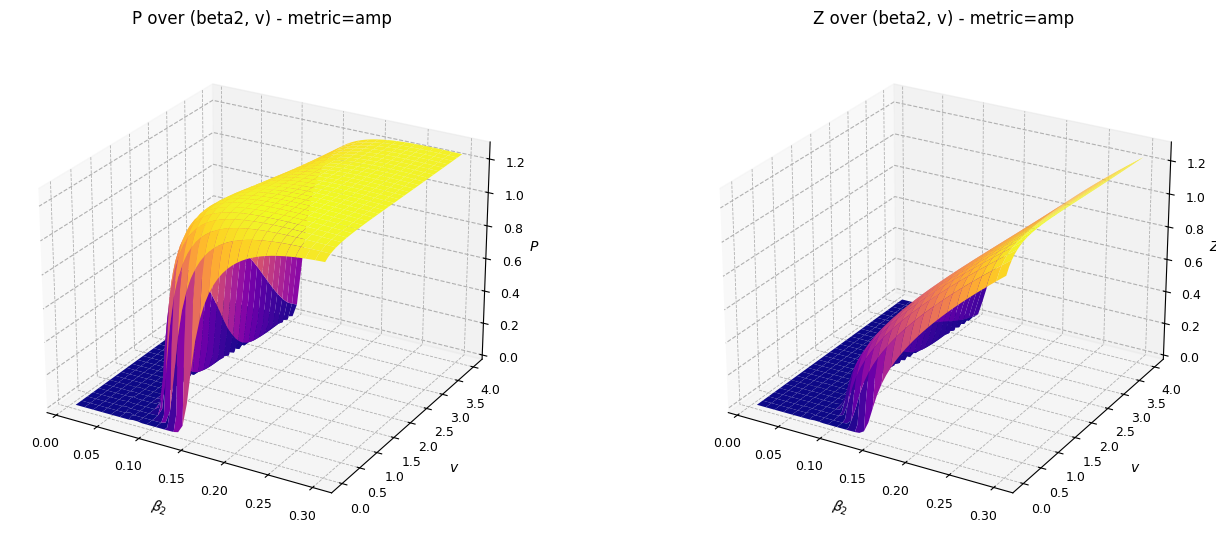

In [ ]:
beta2_vals = np.linspace(0.01, 0.30, 55)
v_vals = np.linspace(0, 4.0, 55)

sweep_and_plot_2params(params, "beta2", beta2_vals, "v", v_vals, metric="mean")
sweep_and_plot_2params(params, "beta2", beta2_vals, "v", v_vals, metric="amp")

/tmp/ipython-input-1567656643.py:33: RuntimeWarning: invalid value encountered in scalar power
  (beta2 * rho * P**(2/3) * Z) - \


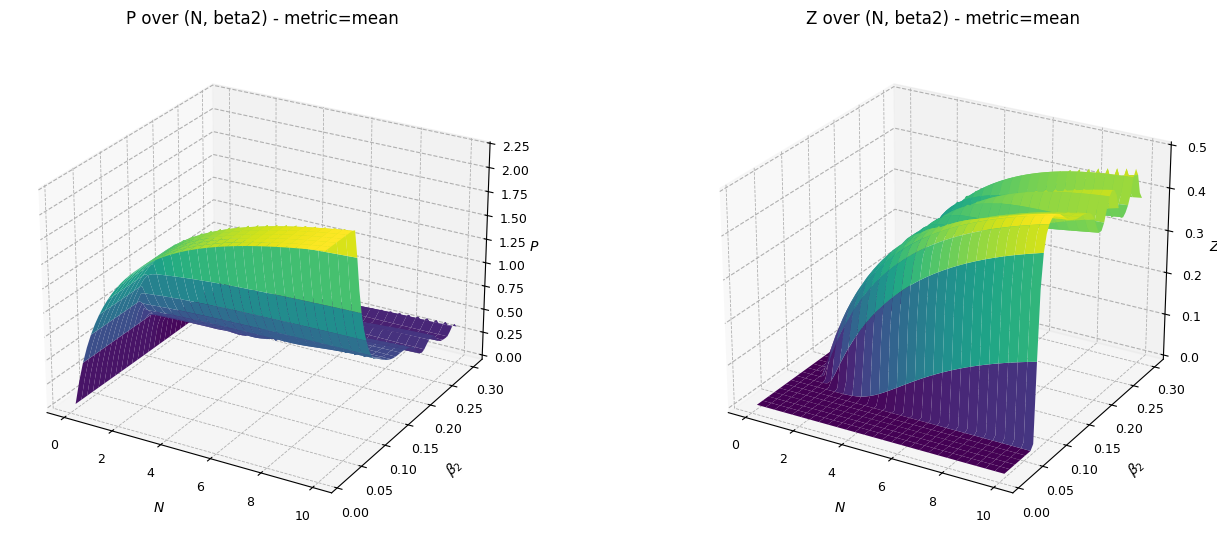

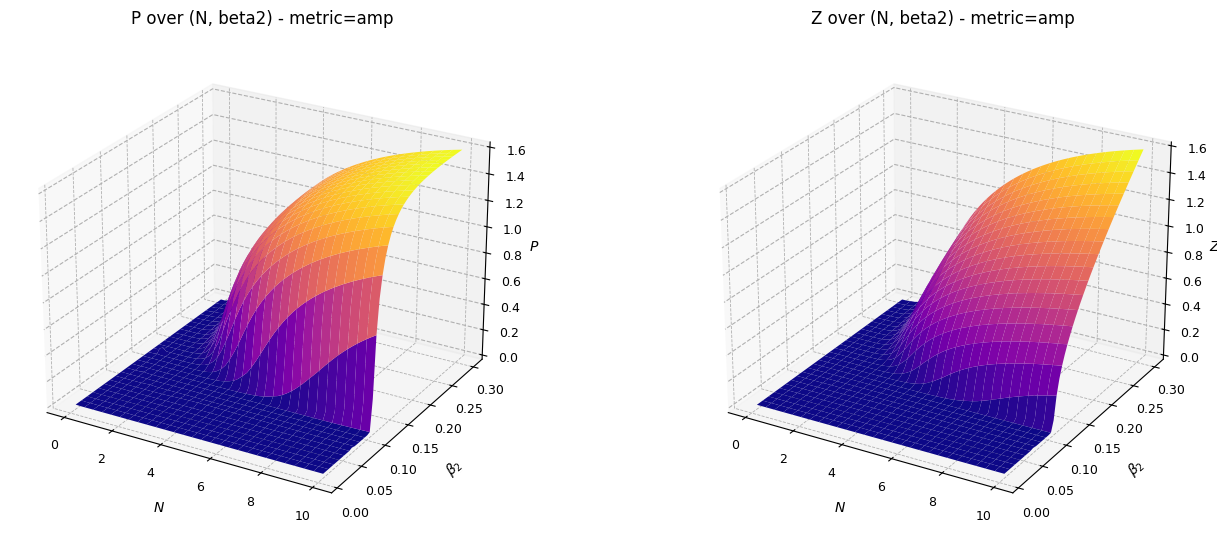

In [ ]:
beta2_vals = np.linspace(0.01, 0.30, 55)
N_vals = np.linspace(0, 10, 55)

sweep_and_plot_2params(params, "N", N_vals, "beta2", beta2_vals, metric="mean")
sweep_and_plot_2params(params, "N", N_vals, "beta2", beta2_vals, metric="amp")

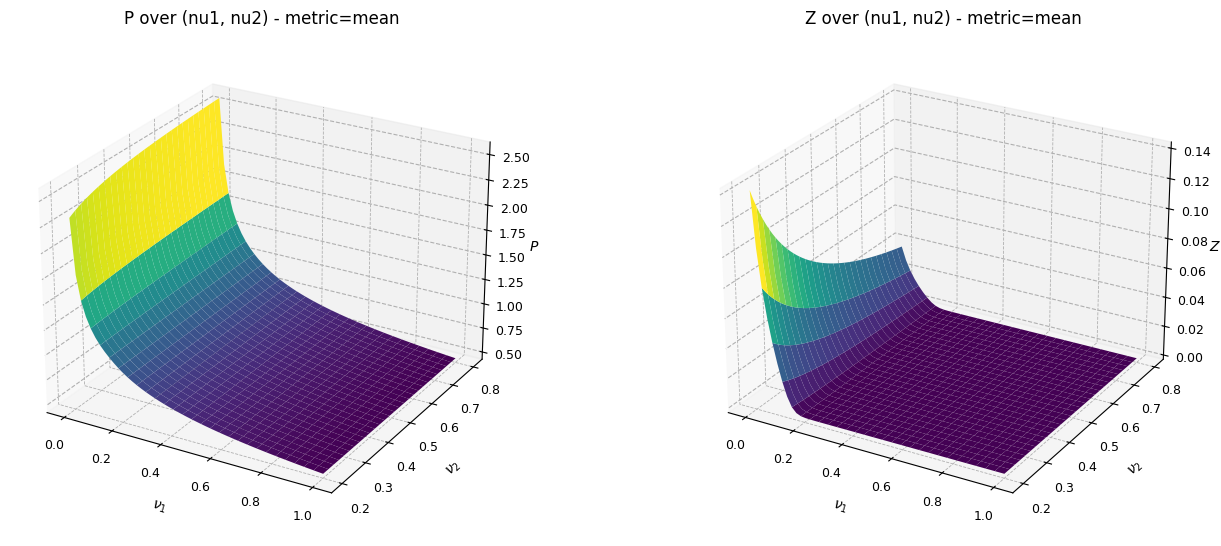

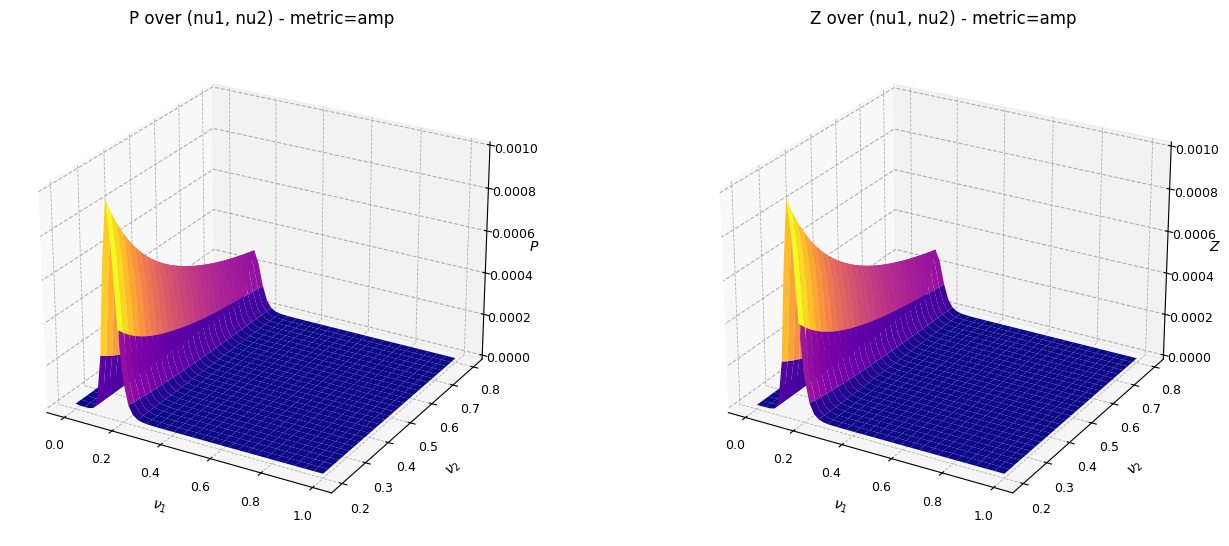

In [ ]:
nu1_vals = np.linspace(0, 1, 55)
nu2_vals = np.linspace(0.2, 0.8, 55)

sweep_and_plot_2params(params, "nu1", nu1_vals, "nu2", nu2_vals, metric="mean")
sweep_and_plot_2params(params, "nu1", nu1_vals, "nu2", nu2_vals, metric="amp")

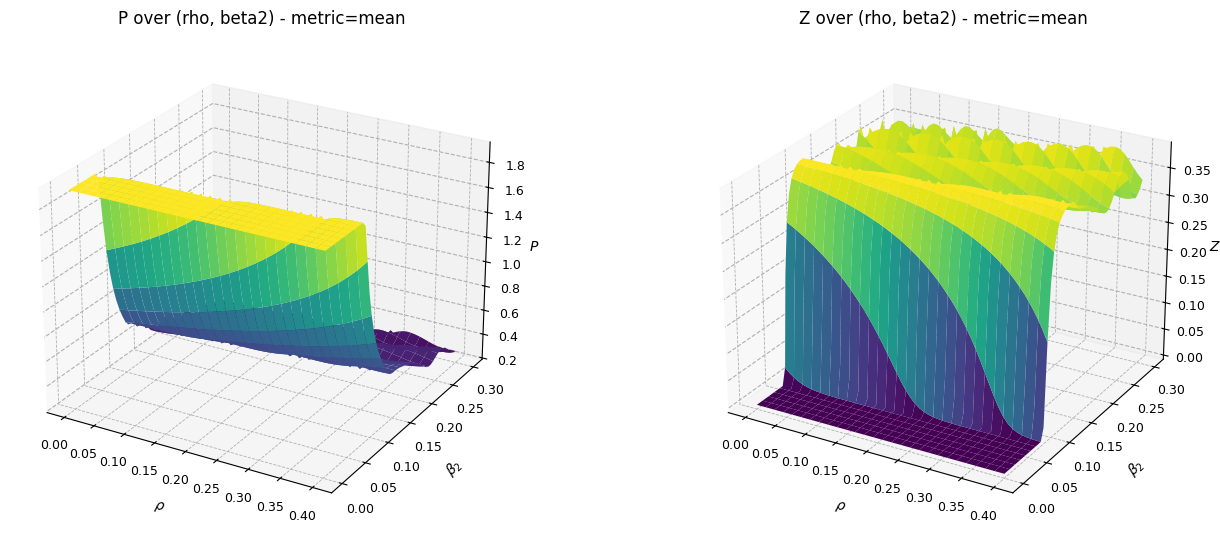

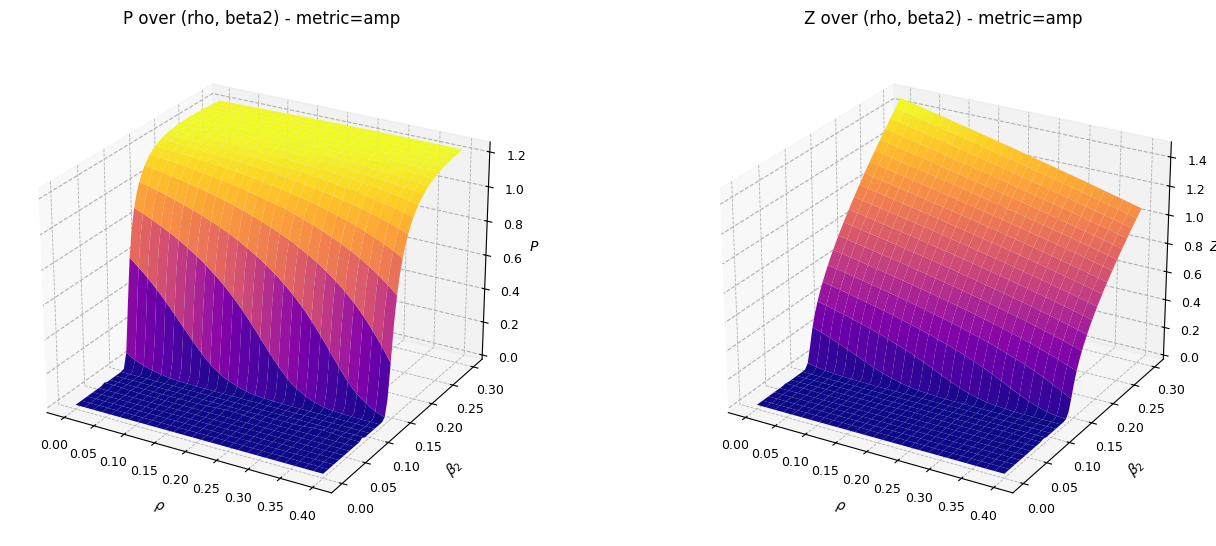

In [ ]:
rho_vals = np.linspace(0, 0.4, 55)
beta2_vals = np.linspace(0, 0.3, 55)

sweep_and_plot_2params(params, "rho", rho_vals, "beta2", beta2_vals, metric="mean")
sweep_and_plot_2params(params, "rho", rho_vals, "beta2", beta2_vals, metric="amp")

**Phân nhánh Hoft**

In [19]:
def plot_bifurcation(
    params,
    type,
    v_vals,
    y0=(2.5, 0.5),
    T=3000.0,
    tail=800.0,
    n_eval=400,
    s=3,
):
    """
    Vẽ sơ đồ phân nhánh Hopf cho tham số v hoặc beta2.
    """

    # chia đều không gian tham số
    X = np.linspace(min(v_vals), max(v_vals), n_eval)

    # tạo mảng kết quả
    Pmin_arr = np.zeros_like(X)
    Pmax_arr = np.zeros_like(X)
    Zmin_arr = np.zeros_like(X)
    Zmax_arr = np.zeros_like(X)

    for i in range(len(X)):
        p = dict(params)

        # gán giá trị tham số đang quét
        if type == 'v':
            p["v"] = float(X[i])
        elif type == 'beta2':
            p["beta2"] = float(X[i])

        # chạy mô phỏng dài hạn
        _, _, _, _, Pmin, Zmin, Pmax, Zmax = long_run_metrics(
            p,
            y0[0], y0[1],
            T=T,
            tail=tail
        )

        Pmin_arr[i] = Pmin
        Pmax_arr[i] = Pmax
        Zmin_arr[i] = Zmin
        Zmax_arr[i] = Zmax

    # Vẽ đồ thị
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    # ---- P ----
    ax1.scatter(X, Pmax_arr, s=s, color="blue", label="max(P)")
    ax1.scatter(X, Pmin_arr, s=s, color="red", label="min(P)")
    ax1.set_xlabel(fr"${param_map[type]}$")
    ax1.set_ylabel(r"$P$")
    ax1.set_title("Phân nhánh của P")
    ax1.grid(True, linestyle="--", alpha=0.4)

    # ---- Z ----
    ax2.scatter(X, Zmax_arr, s=s, color="blue", label="max(Z)")
    ax2.scatter(X, Zmin_arr, s=s, color="red", label="min(Z)")
    ax2.set_xlabel(fr"${param_map[type]}$")
    ax2.set_ylabel(r"$Z$")
    ax2.set_title("Phân nhánh của Z")
    ax2.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()


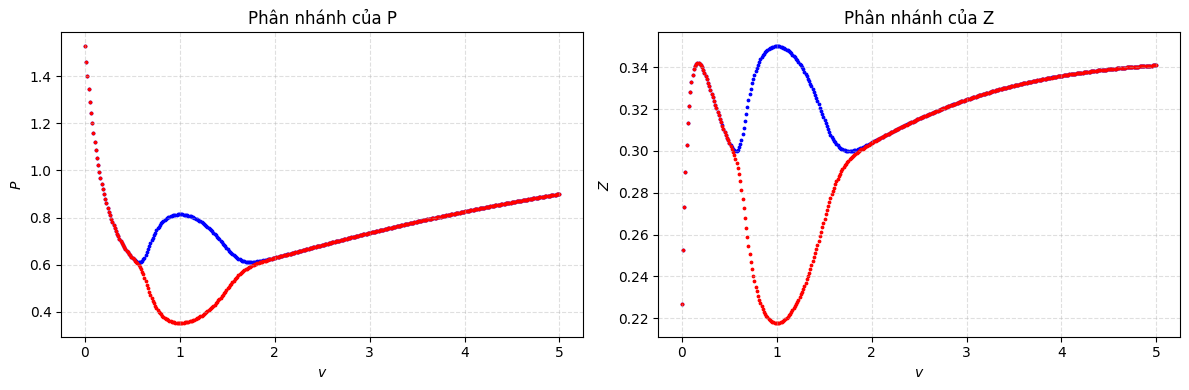

In [44]:
v_vals = np.linspace(0, 5, 10)
plot_bifurcation(params, "v", v_vals)

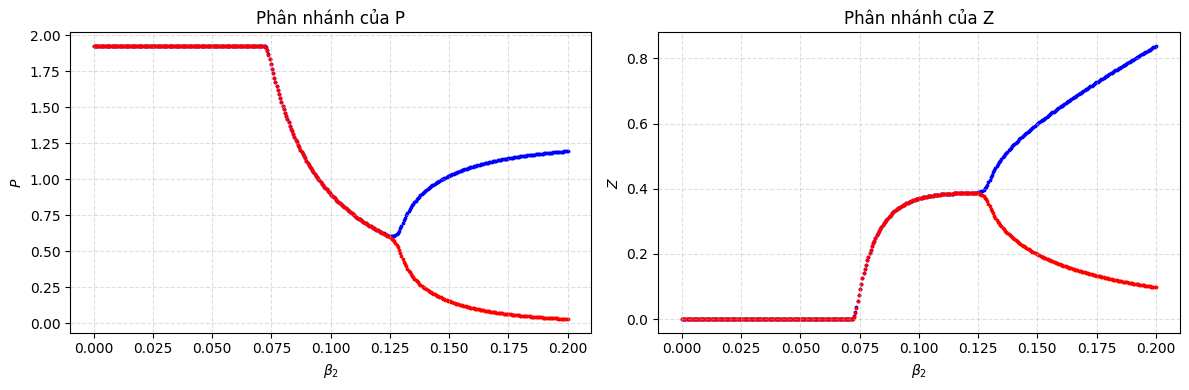

In [20]:
beta2_vals = np.linspace(0, 0.2, 2)
plot_bifurcation(params, "beta2", beta2_vals)